# Tutorial: TensorNet
This notebook will go step by step through one forward pass of the TensorNet architecture.

In [1]:
import torch
from matplotlib import pyplot as plt
from tensornet import *
from sympy import Matrix
import numpy as np

## Data generation
The way the model is implemented, the input for a forward pass consists of a batch of $M$ molecules made up by $N$ atoms in total. For the purpose of this notebook we will create a batch with $M=2$ molecules that are made up by $N=7$ atoms ins total.

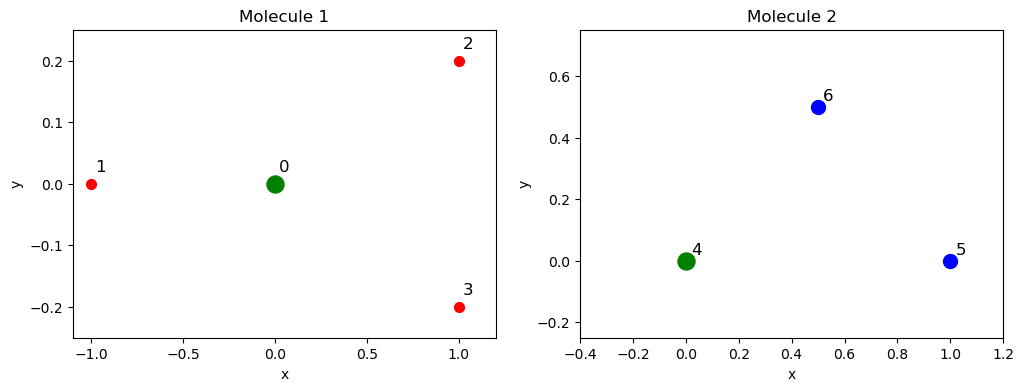

In [2]:
# create 2 molecules with 7 atoms
pos = [[0, 0, 0], [-1, 0, 0], [1, 0.2, 0], [1, -0.2, 0], [0, 0, 0], [1, 0, 0], [0.5, 0.5, 0]]
batch = [0, 0, 0, 0, 1, 1, 1]
atom_ind = [2, 0, 0, 0, 2, 1, 1]
# plot the two molecules
fig, ax = plt.subplots(1,2, figsize=(12,4))
colors = ['r', 'b', 'g']
for n, (atom, mol, ind)  in enumerate(zip(pos, batch, atom_ind)):
    ax[mol].scatter(atom[0], atom[1], c=colors[ind], s=50*(ind+1))
    ax[mol].text(atom[0]+0.02, atom[1]+0.02, str(n), color='black', fontsize=12)
ax[0].set_title('Molecule 1')
ax[1].set_title('Molecule 2')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[0].set_ylim(-0.25, 0.25)
ax[0].set_xlim(-1.1, 1.2)
ax[1].set_ylim(-0.25, 0.75)
ax[1].set_xlim(-0.4, 1.2);

As we can see here, a molecule $\mathcal{M}_i$ is defined by its number of atoms $N_i$, the position of the atoms $\{\vec{r}_n,n=1,...,N_i\}$ and their atomic numbers $\{Z_n,n=1,...,N_i\}$ (where this do not have to be the real atomic number, but they should be different for different atoms).

The way that the model is written, the input to the forward method is an object `batch_input` that has these information as attributes:
- `batch_input.pos`: A tensor of shape $[N,3]$, where the positions of all $N$ atoms are stored
- `batch_input.atom_ind`: A tensor of shape $N$ with the atomic numbers of the $N$ atoms
- `batch_input.batch`: A tensor of shape $[N]$, that defines which atom belongs to which molecule. In our case it would be $[0, 0, 0, 0, 1, 1, 1]$ defining that the first $4$ atoms build the first molecule and the next $3$ the second. Generally this defines the number of molecules $M$ by `max(batch_input.batch)+1=M`.

In [3]:
# define input class
class input():
    def __init__(self, pos, batch, atom_ind):
        self.pos = torch.tensor(pos, dtype=torch.float32)
        self.batch = torch.tensor(batch, dtype=torch.int32)
        self.atom_ind = torch.tensor(atom_ind, dtype=torch.int32)
# define input object
batch_input = input(pos, batch, atom_ind)

## Model initialization
Now we need to initialize the model with the appropriate hyperparameters.

In [4]:
# initialize model
hyperparams = {'hidden_channels': 2,
               'num_layers': 1,
               'max_z': 3,
               'num_rbf': 5,
               'cutoff_lower': 0.0, 
               'cutoff_upper': 1.05, 
               'max_num_neighbors': 4, 
               'activation': "silu",
               'equivariance_invariance_group': "O(3)",
               'check_errors': True, 
               'static_shapes': True,
               'trainable_rbf': True,
               'dtype': "torch.float32"}
model = TensorNet(**hyperparams)
# do the forward pass
output = model(batch_input)
print('Model output:', output)  

[W LinearAlgebra.cpp:3037] Warning: at::frobenius_norm is deprecated and it is just left for JIT compatibility. It will be removed in a future PyTorch release. Please use `linalg.vector_norm(A, 2., dim, keepdim)` instead (function operator())


z tensor([2, 0, 0, 0, 2, 1, 1, 0], dtype=torch.int32)
Z tensor([[-1.3016,  0.2056],
        [ 0.1655, -0.6448],
        [ 0.1655, -0.6448],
        [ 0.1655, -0.6448],
        [-1.3016,  0.2056],
        [ 0.2573, -1.9719],
        [ 0.2573, -1.9719],
        [ 0.1655, -0.6448]], grad_fn=<EmbeddingBackward0>)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Model output: tensor([2.4020, 1.8017], grad_fn=<SumBackward1>)


We can see that the model output are $M$ scalars, describing a scalar quantity (like energy) of the molecules. 

## Graph creation
If one looks into the `tensornet.py`file one can see that the first thing that happpens is the creation of a graph. This is expected, since TensorNet is a Graph-based model but our input was no graph, so it will need to make the input into a graph. The relevant line is

`edge_index, edge_weight, edge_vec = self.distance(pos=pos, batch=batch)`

where `self.distance`is an object from the `OptimizedDistance` class imported from `torchmdnet.models.utils`. This will create a graph by connecting nodes that are seperated by less than `cutoff_upper`(which is a hyperparameter) w.r.t their positions.

In [5]:
# we cant acces the output directly, so we have to calculate it explicitly
from torchmdnet.models.utils import OptimizedDistance
# define distance object
distance = OptimizedDistance(
    hyperparams['cutoff_lower'],
    hyperparams['cutoff_upper'],
    max_num_pairs=-hyperparams['max_num_neighbors'],
    return_vecs=True,
    loop=True,
    check_errors=hyperparams['check_errors'],
    resize_to_fit= not hyperparams['static_shapes'],
    box=None, 
    long_edge_index=True)
# create graph
edge_index, edge_weight, edge_vec = distance(pos=batch_input.pos, batch=batch_input.batch)

In [6]:
print(f'Edge index ({edge_index.shape}):')
display(Matrix(edge_index.numpy()))

Edge index (torch.Size([2, 28])):


Matrix([
[1, 2, 3, 3, 5, 6, 6, 0, 0, 0, 2, 4, 4, 5, 0, 1, 2, 3, 4, 5, 6, -1, -1, -1, -1, -1, -1, -1],
[0, 0, 0, 2, 4, 4, 5, 1, 2, 3, 3, 5, 6, 6, 0, 1, 2, 3, 4, 5, 6, -1, -1, -1, -1, -1, -1, -1]])

In [7]:
print(f'Edge weight ({edge_weight.shape} but shown transposed here):')
display(Matrix(edge_weight.unsqueeze(0).numpy())) 

Edge weight (torch.Size([28]) but shown transposed here):


Matrix([[1.0, 1.0198, 1.0198, 0.4, 1.0, 0.707107, 0.707107, 1.0, 1.0198, 1.0198, 0.4, 1.0, 0.707107, 0.707107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [8]:
print(f'Edge vec ({edge_vec.shape}):')
display(Matrix(edge_vec.numpy()))

Edge vec (torch.Size([28, 3])):


Matrix([
[-1.0,    0, 0],
[ 1.0,  0.2, 0],
[ 1.0, -0.2, 0],
[   0, -0.4, 0],
[ 1.0,    0, 0],
[ 0.5,  0.5, 0],
[-0.5,  0.5, 0],
[ 1.0,    0, 0],
[-1.0, -0.2, 0],
[-1.0,  0.2, 0],
[   0,  0.4, 0],
[-1.0,    0, 0],
[-0.5, -0.5, 0],
[ 0.5, -0.5, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0],
[   0,    0, 0]])

We can see that the graph creation returns three tensors:
- `edge_index`: A tensor of shape $[2, N *$ `max_num_neighbors`], where each column defines the starting and ending node of an edge. If we use `static_shapes=True` the model will enforce static shape for this tensor. This means, the model expects exactly `max_num_neighbors`neighbors for each node and if less neighbors are found it is filles with $(-1,-1)$. One should also note, that the model allows for self-loops. Futhermore, the way we create a graph it is undirected, meaning if $(i,j)$ is an egde, $(j,i)$ is as well.
- `edge_weight`: A tensor of shape $[N *$ `max_num_neighbors`], that defines the length of each edge. Nonexisting edges have length 0.
- `edge_vec`: A tensor of shape $[N *$ `max_num_neighbors`$,3]$, where each row defined the edge vector to that particular edge. Nonexisting edges get a zero vector.
We now want to plot the edges.

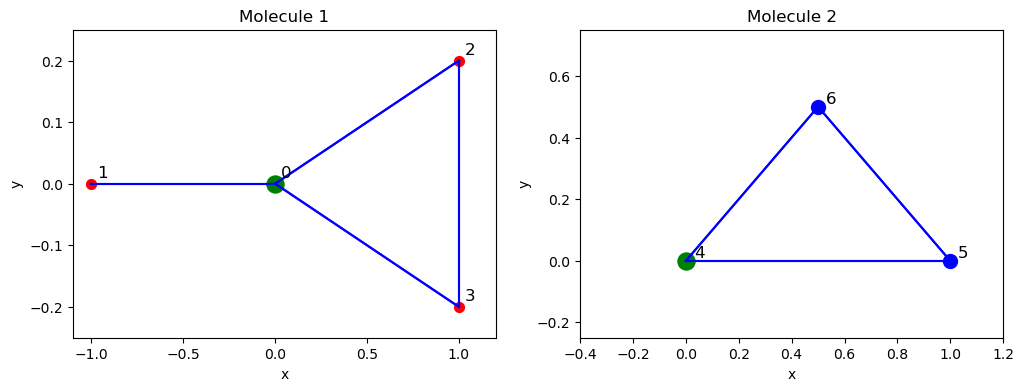

In [9]:
# plot the two molecules
fig, ax = plt.subplots(1,2, figsize=(12,4))
colors = ['r', 'b', 'g']
for n, (atom, mol, ind)  in enumerate(zip(pos, batch, atom_ind)):
    ax[mol].scatter(atom[0], atom[1], c=colors[ind], s=50*(ind+1))
    ax[mol].text(atom[0]+0.03, atom[1]+0.01, str(n), color='black', fontsize=12)
ax[0].set_title('Molecule 1')
ax[1].set_title('Molecule 2')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[0].set_ylim(-0.25, 0.25)
ax[0].set_xlim(-1.1, 1.2)
ax[1].set_ylim(-0.25, 0.75)
ax[1].set_xlim(-0.4, 1.2)
# add edges
for edge, start, end in zip(edge_vec, edge_index[0], edge_index[1]):
    # only take existing edges that are not self loops
    if np.linalg.norm(edge.numpy())>0:
        start_point = pos[start.numpy()]
        end_point = pos[end.numpy()]
        axis = ax[batch[start.numpy()]]
        axis.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'b-')


### Trick: Ghost atom

Enforcing static shapes can increase performance but it means that e.g. `edge_index` will be filled with $(-1,-1)$ pairs until we get the desired shape. One can decrease this effect by adjusting the hyperparameter `max_num_neighbors`, but this will still cause problems later on with operations, since $-1$ is no real node. In the paper they get around this problem by introducing a $N+1$ atom - the ghost atom - and all non-existing edges will be loops of this ghost atoms. This means, that there will be no more $(-1,-1)$ pairs in `edge_index` which helps with operations later on.

In [10]:
# create a mask that is True for the nonexisting edges
mask = (edge_index[0] < 0).unsqueeze(0).expand_as(edge_index)
# I trick the model into thinking that the masked edges pertain to the extra atom with index N=z.shape[0]
edge_index = edge_index.masked_fill(mask, batch_input.atom_ind.shape[0])
# Since we now have N+1 atoms, we need to add the ghost atom to the atomic numbers and choose 0 
z = torch.cat((batch_input.atom_ind, torch.zeros(1, device=batch_input.atom_ind.device, dtype=batch_input.atom_ind.dtype)), dim=0)

In [11]:
# 7 is the index of the ghost atom
print(f'Edge index ({edge_index.shape}):')
display(Matrix(edge_index.numpy()))

Edge index (torch.Size([2, 28])):


Matrix([
[1, 2, 3, 3, 5, 6, 6, 0, 0, 0, 2, 4, 4, 5, 0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7],
[0, 0, 0, 2, 4, 4, 5, 1, 2, 3, 3, 5, 6, 6, 0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7]])

## Preparations for embedding
Before we can call the embedding module, we need to do two things: Normalize the edge vectors and embed the distances.

The expansion of the interatomic distances $r$ in terms of exponential radial basis functions with mean $\mu_k$ and (inverse) variance $\beta_k$ is defined in formula 6 of the paper
$$ e_k^{RBF}(r)=e^{-\beta_k \cdot ( e^{-r}-\mu_k)^2} $$
This expansion is handled by the `ExpNormalSmearing`module. The most important hyperparameter for this are `num_rbf` and `trainable_rbf` which define how many radial basis functions (RBF) are used and if the $\{\mu_k,\beta_k\}$ are trainable parameters.

The initialization is explained in the paper, for our case `num_rbf=5`so we have 5 RBFs:

In [12]:
from tensornet import ExpNormalSmearing
# instantiate the smearing object
distance_expansion = ExpNormalSmearing(
                                         hyperparams['cutoff_lower'],    
                                         hyperparams['cutoff_upper'],
                                         hyperparams['num_rbf'],
                                         trainable=hyperparams['trainable_rbf'],
                                         dtype=torch.float32)
# get inital parameters
print('Initial mu:',distance_expansion.means)
print('Initial beta:',distance_expansion.betas)

Initial mu: Parameter containing:
tensor([0.3499, 0.5125, 0.6750, 0.8375, 1.0000], requires_grad=True)
Initial beta: Parameter containing:
tensor([14.7901, 14.7901, 14.7901, 14.7901, 14.7901], requires_grad=True)


In [13]:
# do the expansion
edge_attr = distance_expansion(edge_weight)
# show difference
print(f'Edge weight ({edge_weight.shape}):')
display(Matrix(edge_weight.detach().numpy()))
print(f'Edge attr ({edge_attr.shape}):')
display(Matrix(np.round(edge_attr.detach().numpy(),3)))

Edge weight (torch.Size([28])):


Matrix([
[     1.0],
[  1.0198],
[  1.0198],
[     0.4],
[     1.0],
[0.707107],
[0.707107],
[     1.0],
[  1.0198],
[  1.0198],
[     0.4],
[     1.0],
[0.707107],
[0.707107],
[       0],
[       0],
[       0],
[       0],
[       0],
[       0],
[       0],
[       0],
[       0],
[       0],
[       0],
[       0],
[       0],
[       0]])

Edge attr (torch.Size([28, 5])):


Matrix([
[0.178, 0.023, 0.001,     0,   0],
[0.177, 0.023, 0.001,     0,   0],
[0.177, 0.023, 0.001,     0,   0],
[ 0.55, 0.142, 0.017, 0.001,   0],
[0.178, 0.023, 0.001,     0,   0],
[ 0.23, 0.034, 0.002,     0,   0],
[ 0.23, 0.034, 0.002,     0,   0],
[0.178, 0.023, 0.001,     0,   0],
[0.177, 0.023, 0.001,     0,   0],
[0.177, 0.023, 0.001,     0,   0],
[ 0.55, 0.142, 0.017, 0.001,   0],
[0.178, 0.023, 0.001,     0,   0],
[ 0.23, 0.034, 0.002,     0,   0],
[ 0.23, 0.034, 0.002,     0,   0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0],
[0.002,  0.03,  0.21, 0.677, 1.0]])

The second thing we have to calculate before the tensor embedding is to normalize the edge vectors. This is pretty straightforward, one only has to take care of self-loops which have length 0 and thus would cause NaNs.

In [14]:
# we need to normalize the edge vectors. Just dividing them by their length will lead to NaNs since there are edges with length 0 
# therefore, all self-loops get a weight of 1 which allows dividing by the length
mask_self_loops = edge_index[0] == edge_index[1]
edge_vec = edge_vec / edge_weight.masked_fill(mask_self_loops, 1).unsqueeze(1)

## Embedding

The next step in the forward pass is to call the `TensorEmbedding` module, which will now populate the graph nodes with tensors. The way we do this is by assigning a tensor to each edge $(ij)$ and then populate the nodes by aggregating (summing up) the tensors of neighboring edges.

If we want to assign a tensor to the edge $(ij)$ we have the following quantities that can be used: Atomic numbers of the neighboring atoms $Z_i,Z_j$, the length of the edge (expanded in RBFs) $e^{RBF}(r_{ij})$ and the normalized edge vector $\hat{\vec{r}}_{ij}$. 

In [17]:
model.tensor_embedding.emb.weight

Parameter containing:
tensor([[ 0.1655, -0.6448],
        [ 0.2573, -1.9719],
        [-1.3016,  0.2056]], requires_grad=True)